Import Libraries/modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings


Load Data

In [3]:
#get data
def load_data(file):
    data= pd.read_csv(file)
    
    # AVG grade of each student
    grad_mean= (data.G1 + data.G2 + data.G3) / 3
    data['G_Mean'] = grad_mean
    data['G_Mean']= data['G_Mean'].round()

    # Generating USN for each student
    data['USN'] = [random.randint(100, 700) for _ in range(len(data))]

    # Define age groups
    data['age_group'] = pd.cut(data['age'], bins=[14, 16, 19, 21], labels=["15-16", "17-19", "20-21"], right=False)

    # Define grade groups using pd.cut
    bins = [-np.inf, 12, 15, 17, np.inf]
    labels = ['Fail', 'Pass', 'Good', 'Excellent']
    data['grade_group'] = pd.cut(data['G_Mean'], bins=bins, labels=labels, right=False)
    return data

file="D:/pythonProject/SPA project/data/student-por.csv"
df= load_data(file)

In [4]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,Walc,health,absences,G1,G2,G3,G_Mean,USN,age_group,grade_group
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,1,3,4,0,11,11,7.0,585,17-19,Fail
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,1,3,2,9,11,11,10.0,213,17-19,Fail
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,3,6,12,13,12,12.0,249,15-16,Pass
3,GP,F,15,U,GT3,T,4,2,health,services,...,1,5,0,14,14,14,14.0,663,15-16,Pass
4,GP,F,16,U,GT3,T,3,3,other,other,...,2,5,0,11,13,13,12.0,416,17-19,Pass


Prepare features and target variable

In [5]:
X=df.drop(columns= ['G_Mean', 'age_group', 'grade_group'], axis=1)
X.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,USN
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,4,0,11,11,585
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,2,9,11,11,213
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,6,12,13,12,249
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,0,14,14,14,663
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,0,11,13,13,416


In [6]:
y= df['G_Mean']
y

0       7.0
1      10.0
2      12.0
3      14.0
4      12.0
       ... 
644    10.0
645    15.0
646    11.0
647    10.0
648    11.0
Name: G_Mean, Length: 649, dtype: float64

Transform the column data

In [7]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

In [8]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [9]:
X = preprocessor.fit_transform(X)
X.shape

(649, 60)

Split the data into training data and testing data

In [10]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

X_train.shape, X_test.shape

((519, 60), (130, 60))

Create a function to specify all the measuring scors used

In [11]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

Specify the models to train

In [12]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

Train all the models 
Make prediction
Evaluate measuring scores

In [13]:
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 0.2582
- Mean Absolute Error: 0.2194
- R2 Score: 0.9916
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.2819
- Mean Absolute Error: 0.2415
- R2 Score: 0.9905


Lasso
Model performance for Training set
- Root Mean Squared Error: 1.0979
- Mean Absolute Error: 0.8617
- R2 Score: 0.8475
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1.1587
- Mean Absolute Error: 0.9273
- R2 Score: 0.8397


Ridge
Model performance for Training set
- Root Mean Squared Error: 0.2582
- Mean Absolute Error: 0.2193
- R2 Score: 0.9916
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.2805
- Mean Absolute Error: 0.2404
- R2 Score: 0.9906


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 0.9710
- Mean Absolute Error: 0.7549
- R2 Score: 0.8808
-----------------------

Compare all models

In [14]:
pd.DataFrame(list(zip(model_list, r2_list)), 
             columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
2,Ridge,0.990605
0,Linear Regression,0.990512
5,Random Forest Regressor,0.989569
6,XGBRegressor,0.989003
7,CatBoosting Regressor,0.982594
4,Decision Tree,0.973358
8,AdaBoost Regressor,0.969508
3,K-Neighbors Regressor,0.840440
1,Lasso,0.839663


Predict using linear regression

In [15]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 99.05


Text(0.5, 1.0, 'y-pred VS y_test')

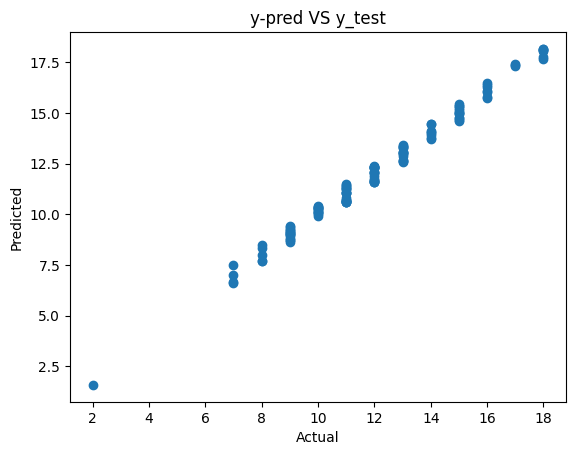

In [16]:
plt.scatter(y_test,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title("y-pred VS y_test")

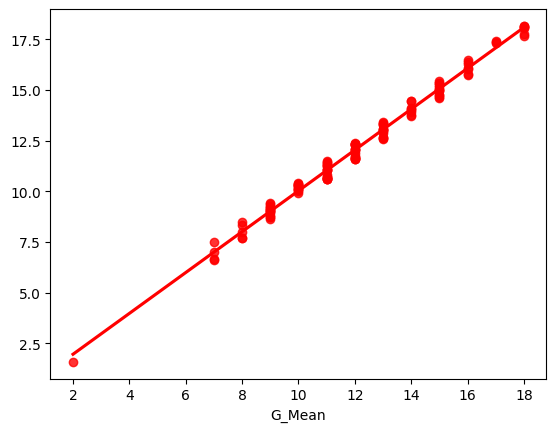

In [17]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

Difference between Actual and Predicted Values

In [18]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
636,18.0,18.155518,-0.155518
220,11.0,11.244141,-0.244141
594,18.0,18.156006,-0.156006
429,11.0,10.691162,0.308838
72,12.0,11.567871,0.432129
...,...,...,...
514,7.0,6.603760,0.396240
374,17.0,17.379639,-0.379639
444,10.0,10.093750,-0.093750
244,13.0,12.634277,0.365723


Predict using Ridge regression

In [19]:
reg_model = Ridge(fit_intercept=True)
reg_model = lin_model.fit(X_train, y_train)
y_pred1 = lin_model.predict(X_test)
score1 = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score1)

 Accuracy of the model is 99.05


Text(0.5, 1.0, 'y-pred VS y_test')

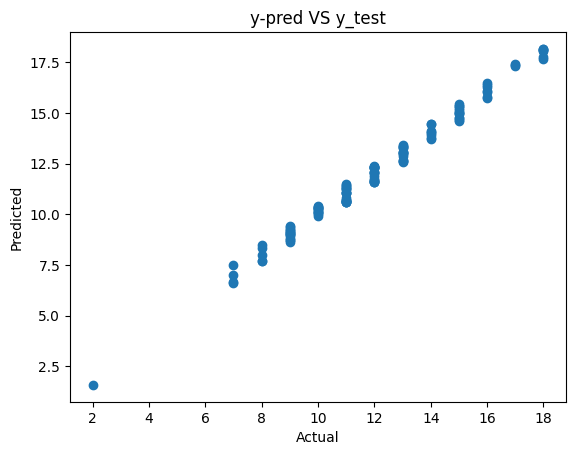

In [20]:
plt.scatter(y_test,y_pred1)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title("y-pred VS y_test")

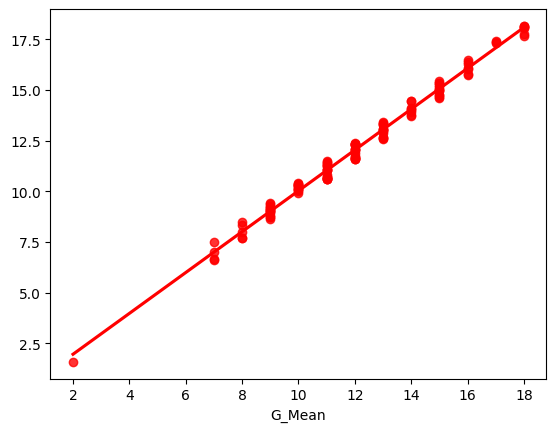

In [21]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

In [22]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
636,18.0,18.155518,-0.155518
220,11.0,11.244141,-0.244141
594,18.0,18.156006,-0.156006
429,11.0,10.691162,0.308838
72,12.0,11.567871,0.432129
...,...,...,...
514,7.0,6.603760,0.396240
374,17.0,17.379639,-0.379639
444,10.0,10.093750,-0.093750
244,13.0,12.634277,0.365723
